In [1]:
%matplotlib inline
import warnings; warnings.filterwarnings("ignore")

# Results
This file presents and organizes the last results used in the thesis.

In [2]:
# Python imports
import torch
import pandas as pd
import seaborn as sns
from pathlib import Path
from IPython.display import display # show multiple tables in one cell

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D
import matplotlib.patches as patches

# Local imports
from experiment import Experiment
from util import save_results_to_csv
from config import WEIGHTS_DIR, RESULTS_DIR
from methods.visualize import visualize_predictions
from methods.error_analyzer import analyze_model_predictions

RESULTS_CSV = RESULTS_DIR / 'results.csv'  # where the final test metrics and speed metrics will be saved

RUN_INFERENCE = False  # inference for all models and t_clip values can take a long time, if stage results are saved, and this variable set to false,
                       # we will skip these runs and load from local
stage_names = ['stage1', 'stage2', 'stage3']  
all_exist = all((RESULTS_DIR / f"{stage}_results.pkl").exists() for stage in stage_names) # if the local saves don't exist, we will run the inference
RUN_INFERENCE = not all_exist

RUN_INFERENCE

False

In [3]:
BASE_CONFIG = {
    'ckpt_dir': RESULTS_DIR,
    'dataset_dir': 'both',
    'gpus': 0,
    'num_workers': 0,
    'max_epochs': 0,
    'effective_batch_size': 1,
    'repeat_channels': 1,
    'deterministic': True,
    'model_stage': 1,  # placeholder for Experiment init, will be overridden later
    'use_augmentation': False,

    'num_log_test_images': 0,

    # Stage 2 and 3 specific:
    'subsegment': True,
    'use_sca': True,
    'jitter': False,

    'verbose': False,  # otherwise each config, model and PL is very verbose.
}

COMMON_SPEED_TEST_CONFIG = {
    'num_warmup': 10,
    'num_iterations': 100,
}
exp_runner = Experiment(config=BASE_CONFIG)
print(f'Using dataset: {exp_runner.config.get('dataset_dir')}')

Using dataset: both


### Testing Logic
This wrapper function is used to:
- Test model given the Experiment class instance, a checkpoint and the model stage
- Accepts custom user overrides that are passed onto the Experiment instance
- Accepts common test configuration that is an optional dictionary of common parameters for metric evaluation runs
- Accepts optional dictionary for speed measurement runs
- **Note:** Due to the handing of worker seeding, for every run the seed is set once again with Lightning's seed_everything() function. 

In [4]:
def test_model_checkpoint(
    experiment_runner: Experiment,
    checkpoint_path: Path,
    model_stage: int,
    test_specific_overrides: dict | None = None,
    common_test_config: dict | None = None,
    speed_test_config: dict | None = None,
) -> dict:

    if not RUN_INFERENCE: return  # skip

    if not checkpoint_path.exists():
        raise FileNotFoundError(f'Checkpoint path not found. Cannot load checkpoint: {checkpoint_path}')

    print(f"\n--- Testing {checkpoint_path.name} (Stage {model_stage}) ---")

    overrides_config = test_specific_overrides or {}
    common_test_config = common_test_config or {}
    speed_test_config  = speed_test_config  or {}
    base_cfg = {
        "model_stage": model_stage,
        "test_model_path": str(checkpoint_path),
    }

    metrics_cfg = {**common_test_config, **overrides_config, **base_cfg}
    speed_cfg = {**common_test_config, **overrides_config, **speed_test_config, **base_cfg}

    # metric run
    print("Running metric evaluation...")
    test_results = experiment_runner.run_test(testing_config_overrides=metrics_cfg)
    if test_results and test_results.get("final_test_metrics"):  # pandas for prettier prints
        print(pd.DataFrame([test_results["final_test_metrics"]]).to_string(index=False))
    else:
        print("No test metrics returned.")

    # speed run
    print("Measuring inference speed …")
    inference_stats = experiment_runner.measure_inference_speed(
        testing_config_overrides=speed_cfg,
        num_warmup=speed_test_config.get("num_warmup", 10),
        num_iterations=speed_test_config.get("num_iterations", 100),
    )

    if inference_stats and "error" not in inference_stats:
        print(pd.DataFrame([inference_stats]).to_string(index=False))
    elif inference_stats:
        print(f"Speed-test error: {inference_stats.get('error')}")
    else:
        print("No speed stats returned.")

    return {
        "test_results": test_results,  # this is actually a quite large dict with all of the predictions as well, to be used for vis.
        "inference_speed_stats": inference_stats,
        "checkpoint_path": str(checkpoint_path),
        "model_stage": model_stage,
        "run_config_metrics": metrics_cfg.copy(),
        "run_config_speed": speed_cfg.copy(),
    }


## Results for Stage 1 Model (FPNRetinaNet)

In [5]:
stage1_weights = WEIGHTS_DIR / 'stage1/weights.ckpt'
model_name = 'fpn'
stage1_results = test_model_checkpoint(
    experiment_runner=exp_runner,
    checkpoint_path=stage1_weights,
    model_stage=1,
    speed_test_config=COMMON_SPEED_TEST_CONFIG,
    test_specific_overrides={'batch_size': 4}
)

if stage1_results and RUN_INFERENCE:
    save_results_to_csv(stage1_results, RESULTS_CSV, model_name=model_name)

## Results for Stage 2 Model (TSMRetinaNet)
Here, the weights are loaded from the `WEIGHTS_DIR / stage2` directory. Each weight file is named as `t{val}_weights.ckpt` (e.g., `t1_weights.ckpt`) for t_clip values of 1, 4, 8, 16, 24.

In [6]:
stage2_results = {}
t_clip_values_tsm = [1, 4, 8, 16, 24]  # thanos does not have t_clip=24
tsm_weights_dir = WEIGHTS_DIR / 'stage2'

for t_clip_val in t_clip_values_tsm:
    model_name = f'tsm_t{t_clip_val}' # Made name more specific
    weight_ckpt = tsm_weights_dir / f"t{t_clip_val}_weights.ckpt"
    override_conf = {'t_clip': t_clip_val, 'batch_size': 1}

    results = test_model_checkpoint(
        experiment_runner=exp_runner, checkpoint_path=weight_ckpt, model_stage=2,
        speed_test_config=COMMON_SPEED_TEST_CONFIG, test_specific_overrides=override_conf
    )

    if results and RUN_INFERENCE:
        stage2_results[model_name] = results
        save_results_to_csv(results, RESULTS_CSV, model_name=model_name)

## Results for Stage 3 Model (THANOS)
Due to computational limitations (even in HPC) for the THANOS model, `t_clip=24` is not included.

In [7]:
stage3_results = {}
t_clip_values_thanos = [1, 4, 8, 16]  # thanos does not have t_clip=24
thanos_weights_dir = WEIGHTS_DIR / 'stage3'

for t_clip_val in t_clip_values_thanos:
    model_name = f'thanos_t{t_clip_val}' # Made name more specific
    weight_ckpt = thanos_weights_dir / f"t{t_clip_val}_weights.ckpt"
    override_conf = {'t_clip': t_clip_val, 'batch_size': 1}

    results = test_model_checkpoint(
        experiment_runner=exp_runner, checkpoint_path=weight_ckpt, model_stage=3,
        speed_test_config=COMMON_SPEED_TEST_CONFIG, test_specific_overrides=override_conf
    )

    if results and RUN_INFERENCE:
        stage3_results[model_name] = results
        save_results_to_csv(results, RESULTS_CSV, model_name=model_name)

## Save the Results of Each Stage
Save as binary file as there are objects within the dictionaries. 

In [8]:
import pickle

all_results = [stage1_results, stage2_results, stage3_results]

if RUN_INFERENCE:
    for results_dict, stage_name in zip(all_results, stage_names):    
        pickle_filename = f'{stage_name}_results.pkl'
        pickle_filepath = RESULTS_DIR / pickle_filename
        
        with open(pickle_filepath, 'wb') as f:
            pickle.dump(results_dict, f)



Then, instead of running the inference again, the following files can be loaded directly from local:

In [9]:
with open(RESULTS_DIR / 'stage1_results.pkl', 'rb') as f:
    stage1_results_local = pickle.load(f)

with open(RESULTS_DIR / 'stage2_results.pkl', 'rb') as f:
    stage2_results_local = pickle.load(f)

with open(RESULTS_DIR / 'stage3_results.pkl', 'rb') as f:
    stage3_results_local = pickle.load(f)

# Visualizations
For simpler processing, we will load results from the saved CSV file. 

In [10]:
# First, set some defaults for vis style:
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    "font.size": 20,
    "axes.labelsize": 20,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "legend.fontsize": 20,
    "figure.dpi": 100,      
    "savefig.dpi": 300,      
    "savefig.bbox": "tight"  
})

LINE_WIDTH = 2.5
MARKER_SIZE = 8

# set colors
colors = {
    "FPNRetinaNet": "lightcoral",
    "TSMRetinaNet": "forestgreen",
    "THANOS": "steelblue",
}

# load the data and map the model names
df = pd.read_csv(RESULTS_CSV)

stage_map = {1: "FPNRetinaNet", 2: "TSMRetinaNet", 3: "THANOS"}
df["stage_name"] = df["stage"].map(stage_map)

baseline = df.loc[df["stage_name"] == "FPNRetinaNet"].iloc[0]
tsm = df.loc[df["stage_name"] == "TSMRetinaNet"].sort_values("t_clip")
thanos = df.loc[df["stage_name"] == "THANOS"].sort_values("t_clip")

df

model_name  stage  t_clip    mAP  mAR_100  AvgIoU_TP_0.5  AP_small  \
0         fpn      1     NaN  0.427    0.491          0.707     0.252   
1      tsm_t1      2     1.0  0.000    0.000          0.000     0.000   
2      tsm_t4      2     4.0  0.481    0.576          0.685     0.033   
3      tsm_t8      2     8.0  0.590    0.616          0.712     0.055   
4     tsm_t16      2    16.0  0.727    0.812          0.693     0.125   
5     tsm_t24      2    24.0  0.796    0.845          0.697     0.215   
6   thanos_t1      3     1.0  0.000    0.000          0.000     0.000   
7   thanos_t4      3     4.0  0.551    0.620          0.673     0.051   
8   thanos_t8      3     8.0  0.645    0.689          0.705     0.183   
9  thanos_t16      3    16.0  0.606    0.724          0.687     0.096   

   Precision  Recall     F1  avg_time_ms_batch  avg_latency_ms_batch  \
0      0.634   0.491  0.554              351.0                  87.7   
1      0.000   0.000  0.000               82.1                  82.1   
2      0.542   0.565  0.553              334.7                 334.7   
3      0.609   0.616  0.612              667.4                 667.4   
4      0.534   0.806  0.642             1349.1                1349.1   
5      0.550   0.841  0.665            23781.0               23781.0   
6      0.000   0.000  0.000              239.0                 239.0   
7      0.556   0.598  0.576              865.3                 865.3   
8      0.626   0.689  0.656             1669.9                1669.9   
9      0.515   0.718  0.600             3348.6                3348.6   

   avg_latency_ms_frame   fps    stage_name  
0                  87.7  11.4  FPNRetinaNet  
1                  82.1  12.2  TSMRetinaNet  
2                  83.7  12.0  TSMRetinaNet  
3                  83.4  12.0  TSMRetinaNet  
4                  84.3  11.9  TSMRetinaNet  
5                 990.9   1.0  TSMRetinaNet  
6                 239.0   4.2        THANOS  
7                 216.3   4.6        THANOS  
8                 208.7   4.8        THANOS  
9                 209.3   4.8        THANOS

## Figure 1: Impact of Temporal Context on mAP and FPS

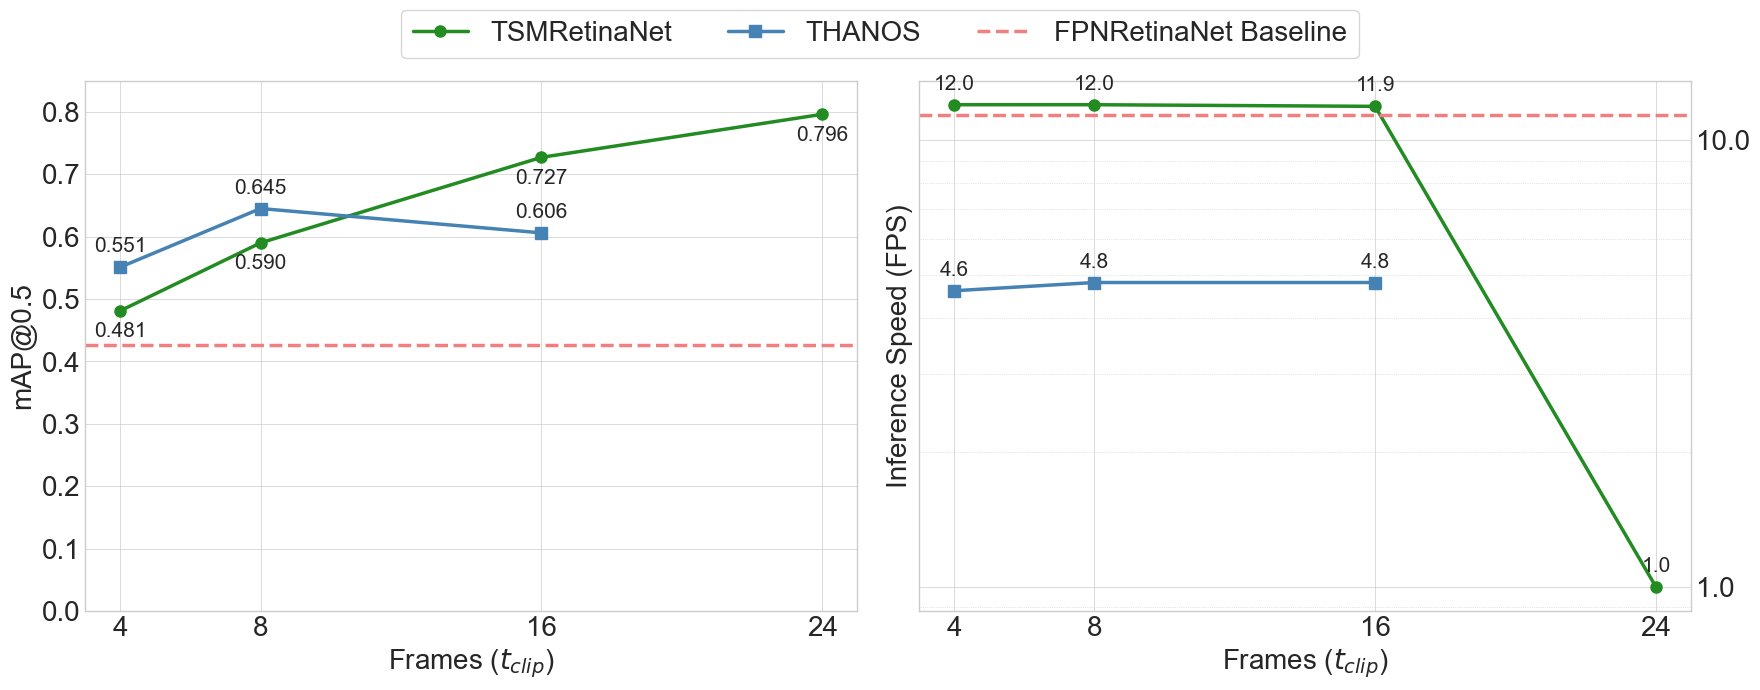

In [11]:
# filter out t_clip=1
tsm = tsm[tsm['t_clip'] >= 4]
thanos = thanos[thanos['t_clip'] >= 4]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharex=True)

# plot 1: mAP vs. tclip 
ax1.plot(tsm["t_clip"], tsm["mAP"], marker='o', linestyle='-', label="TSMRetinaNet", color=colors["TSMRetinaNet"], lw=LINE_WIDTH, ms=MARKER_SIZE)
ax1.plot(thanos["t_clip"], thanos["mAP"], marker='s', linestyle='-', label="THANOS", color=colors["THANOS"], lw=LINE_WIDTH, ms=MARKER_SIZE)
ax1.axhline(y=baseline["mAP"], linestyle='--', label="FPNRetinaNet Baseline", color=colors["FPNRetinaNet"], lw=LINE_WIDTH)

ax1.set_xlabel("Frames ($t_{clip}$)") 
ax1.set_ylabel("mAP@0.5")
ax1.set_ylim(0, 0.85)

# plot 2: fps vs. tclip 
ax2.plot(tsm["t_clip"], tsm["fps"], marker='o', linestyle='-', color=colors["TSMRetinaNet"], lw=LINE_WIDTH, ms=MARKER_SIZE)
ax2.plot(thanos["t_clip"], thanos["fps"], marker='s', linestyle='-', color=colors["THANOS"], lw=LINE_WIDTH, ms=MARKER_SIZE)
ax2.axhline(y=baseline["fps"], linestyle='--', color=colors["FPNRetinaNet"], lw=LINE_WIDTH)

ax2.set_xlabel("Frames ($t_{clip}$)")
ax2.set_ylabel("Inference Speed (FPS)")
ax2.set_yscale('log')
ax2.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax2.yaxis.set_minor_formatter(mticker.NullFormatter())
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("left")


# add values annotations
# labels for mAP plot
for _, row in tsm.iterrows():
    ax1.annotate(f"{row['mAP']:.3f}", xy=(row['t_clip'], row['mAP']), ha='center', va='top', fontsize=15, xytext=(0, -8), textcoords='offset points')
for _, row in thanos.iterrows():
    ax1.annotate(f"{row['mAP']:.3f}", xy=(row['t_clip'], row['mAP']), ha='center', va='bottom', fontsize=15, xytext=(0, 8), textcoords='offset points')

# labels for fps
for _, row in tsm.iterrows():
    ax2.annotate(f"{row['fps']:.1f}", xy=(row['t_clip'], row['fps']), ha='center', va='bottom', fontsize=15, xytext=(0, 8), textcoords='offset points')
for _, row in thanos.iterrows():
    ax2.annotate(f"{row['fps']:.1f}", xy=(row['t_clip'], row['fps']), ha='center', va='bottom', fontsize=15, xytext=(0, 8), textcoords='offset points')


plt.xticks([4, 8, 16, 24])

for ax in [ax1, ax2]:
    ax.grid(True, which='major', linestyle='-', linewidth=0.5)
    if ax == ax2:
        ax.grid(True, which='minor', linestyle=':', linewidth=0.5)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=3, frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig(RESULTS_DIR / "ex_temporal_context.png")
plt.show()

## Figure 2: Comparison of Best-Performing Stages

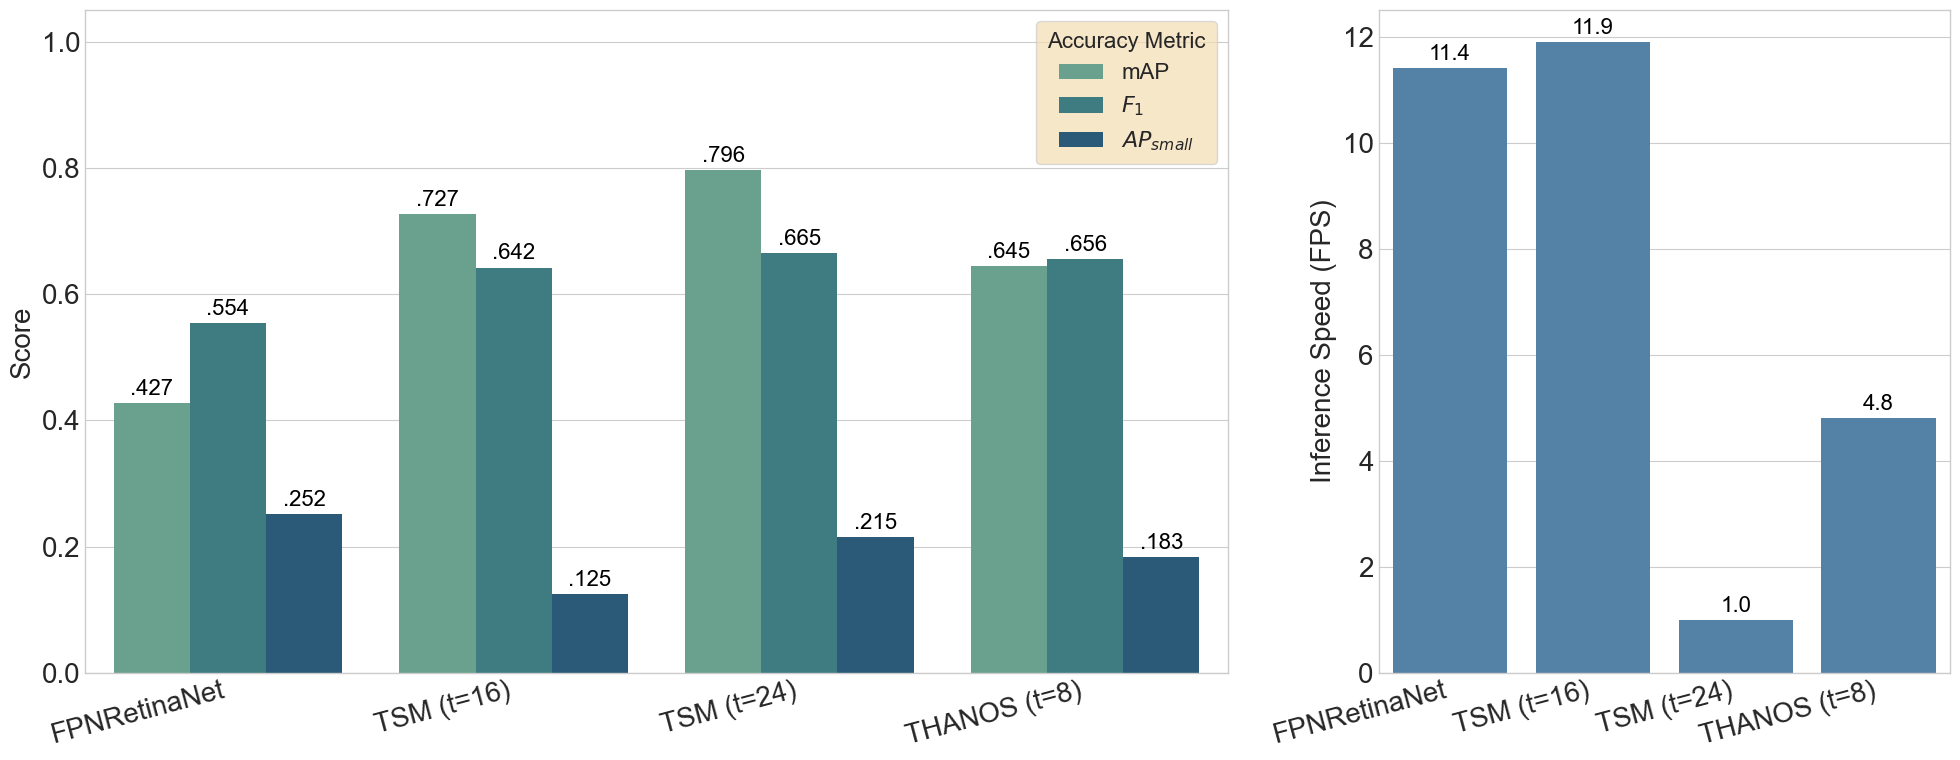

In [12]:
# 1. select data, create labels
configs_to_compare = [
    (df['stage_name'] == 'FPNRetinaNet'),
    (df['stage_name'] == 'TSMRetinaNet') & (df['t_clip'] == 16),
    (df['stage_name'] == 'TSMRetinaNet') & (df['t_clip'] == 24),
    (df['stage_name'] == 'THANOS') & (df['t_clip'] == 8)
]
df_compare = pd.concat([df[cond] for cond in configs_to_compare]).reset_index(drop=True)
df_compare['config_label'] = ['FPNRetinaNet', 'TSM (t=16)', 'TSM (t=24)', 'THANOS (t=8)']

# 2. prepare data
df_melted = df_compare.melt(
    id_vars=['config_label'], value_vars=['mAP', 'F1', 'AP_small'],
    var_name='Metric', value_name='Score'
)
df_melted['Metric'] = df_melted['Metric'].replace({
    'mAP': 'mAP', 'F1': r'$F_1$', 'AP_small': r'$AP_{small}$'
})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), gridspec_kw={'width_ratios': [3, 1.5]})

# plot 1: metrics 
sns.barplot(data=df_melted, x='config_label', y='Score', hue='Metric', palette='crest', ax=ax1)
ax1.set_xlabel('')
ax1.set_ylabel('Score')
ax1.set_ylim(0, 1.05)

# custom legend 
handles, labels = ax1.get_legend_handles_labels()
ax1.get_legend().remove()
ax1.legend(
    handles=handles, labels=labels,
    title='Accuracy Metric', title_fontsize='16', fontsize='16',
    loc='upper right', facecolor='wheat', framealpha=0.7,
    frameon=True, fancybox=True, shadow=False, borderpad=0.5
)

# plot 2: inference speed
sns.barplot(data=df_compare, x='config_label', y='fps',
            color="steelblue", 
            ax=ax2)

ax2.set_xlabel('')
ax2.set_ylabel('Inference Speed (FPS)')
ax2.set_ylim(0, 12.5)

# 4. add bar labels
def score_formatter(x): return f'{x:.3f}'.replace('0.', '.')
def fps_formatter(x): return f'{x:.1f}'
for c in ax1.containers: ax1.bar_label(c, fmt=score_formatter, label_type='edge', padding=3, fontsize=16, color='black')
for c in ax2.containers: ax2.bar_label(c, fmt=fps_formatter, label_type='edge', padding=3, fontsize=16, color='black')

# 5. final adjustments
for ax in [ax1, ax2]: ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha='right')
plt.tight_layout()
plt.savefig(RESULTS_DIR / "ex_model_comparison.png")
plt.show()

## Figure 3: Accuracy vs. Speed Trade-Off

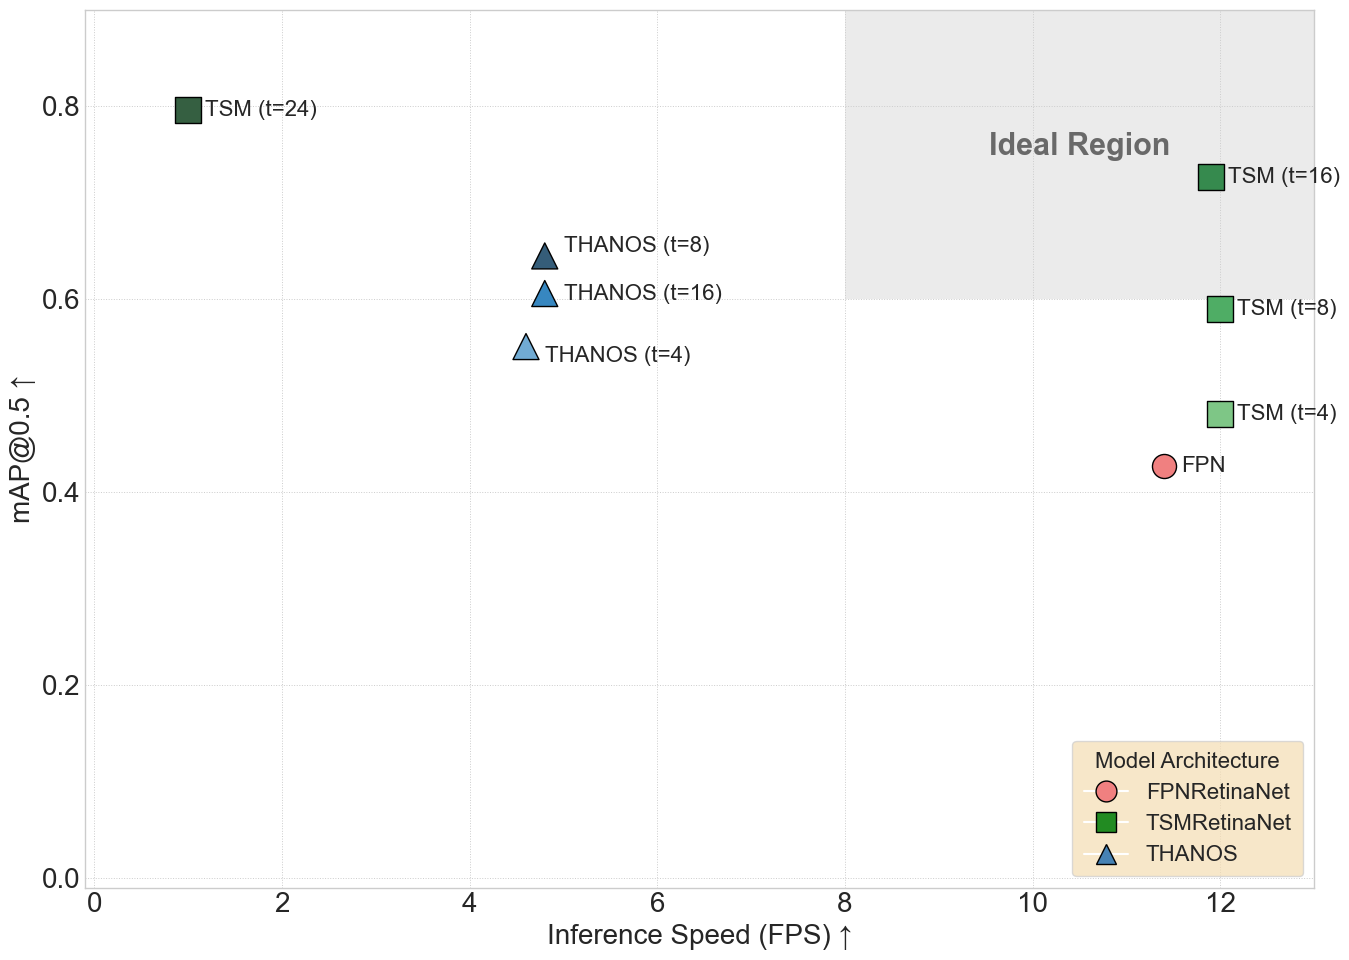

In [13]:
# 1. prepare data
df_plot = df[df['mAP'] > 0].copy()
def create_point_label(row):
    if row['stage_name'] == 'FPNRetinaNet': return 'FPN'
    else: return f"{row['stage_name'].replace('RetinaNet', '')} (t={int(row['t_clip'])})"
df_plot['point_label'] = df_plot.apply(create_point_label, axis=1)

fig, ax = plt.subplots(figsize=(14, 10))

# 3. draw the ideal region, this must be drawn first so it's in the background
ideal_zone = patches.Rectangle(
    (8, 0.6), 5, 0.3,
    linewidth=0,
    edgecolor='none',
    facecolor='silver',
    alpha=0.3,
    zorder=0
)
ax.add_patch(ideal_zone)
ax.text(10.5, 0.75, 'Ideal Region', fontsize=22, fontweight='bold', ha='center', color='dimgray')


# 4. plot each model family
# FPN
fpn_data = df_plot[df_plot['stage_name'] == 'FPNRetinaNet']
ax.scatter(fpn_data['fps'], fpn_data['mAP'], marker='o', s=300, color='lightcoral', edgecolor='black', linewidth=1, label='FPNRetinaNet', zorder=5)

# TSM 
tsm_data = df_plot[df_plot['stage_name'] == 'TSMRetinaNet'].sort_values('mAP')
tsm_palette = sns.color_palette("Greens_d", n_colors=len(tsm_data))
ax.scatter(tsm_data['fps'], tsm_data['mAP'], marker='s', s=350, c=tsm_palette, edgecolor='black', linewidth=1, label='TSMRetinaNet', zorder=5)

# THANOS
thanos_data = df_plot[df_plot['stage_name'] == 'THANOS'].sort_values('mAP')
thanos_palette = sns.color_palette("Blues_d", n_colors=len(thanos_data))
ax.scatter(thanos_data['fps'], thanos_data['mAP'], marker='^', s=350, c=thanos_palette, edgecolor='black', linewidth=1, label='THANOS', zorder=5)

# 5. custom offsets for intelligent label placement to avoid overlap
label_adjustments = {
    'THANOS (t=8)':  (0.2, 0.01),
    'THANOS (t=16)': (0.2, 0.0),
    'THANOS (t=4)':  (0.2, -0.01),
}
for idx, row in df_plot.iterrows():
    label = row['point_label']
    ha = 'left'
    offset = label_adjustments.get(label, (0.18, 0))
    ax.text(row['fps'] + offset[0], row['mAP'] + offset[1], label, fontsize=16, va='center', ha=ha, zorder=6)

# 6. styling
ax.set_xlabel(r"Inference Speed (FPS) ↑")
ax.set_ylabel("mAP@0.5 ↑")
ax.set_xlim(left=-0.1, right=13)
ax.set_ylim(bottom=-0.01, top=0.9)
ax.grid(True, which='both', linestyle=':', linewidth=0.7)

# 7. legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='FPNRetinaNet', markerfacecolor='lightcoral', markeredgecolor='black', markersize=15),
    Line2D([0], [0], marker='s', color='w', label='TSMRetinaNet', markerfacecolor='forestgreen', markeredgecolor='black', markersize=15),
    Line2D([0], [0], marker='^', color='w', label='THANOS', markerfacecolor='steelblue', markeredgecolor='black', markersize=15)
]
ax.legend(
    handles=legend_elements,
    title='Model Architecture',
    title_fontsize='16',
    fontsize='16',
    loc='lower right', 
    facecolor='wheat',
    framealpha=0.7,
    frameon=True,
    fancybox=True,
    shadow=False,
    borderpad=0.5
)
plt.tight_layout()
plt.savefig(RESULTS_DIR / "ex_accuracy_vs_speed.png")
plt.show()

# Qualitative Error Analysis

In [14]:
# will also need the reader here to request the images from memory
reader = exp_runner.reader

models_to_analyze = {
    'fpn': stage1_results_local['test_results']['final_test_results'],
    'tsm_t16': stage2_results_local['tsm_t16']['test_results']['final_test_results'],
    'thanos_t16': stage3_results_local['thanos_t16']['test_results']['final_test_results'],
}

analyzed_data = analyze_model_predictions(models_to_analyze) # will produce a dict for each frame/clip including whether the pred. was a TP/FP/FN

df_predictions = pd.DataFrame(analyzed_data)
df_predictions.head()

[22:35:52][experiment.Experiment.prepare_for_testing] "Preparing for testing with overrides: {'model_stage': 2, 'test_model_path': '.'}"


model_id  patient_id  video_id item_type  frame_nr  clip_start_frame  \
0      fpn          27         4     frame      17.0               NaN   
1      fpn          27         4     frame      18.0               NaN   
2      fpn          27         4     frame      19.0               NaN   
3      fpn          27         4     frame      20.0               NaN   
4      fpn          27         4     frame      21.0               NaN   

   clip_end_frame  num_tp  num_fp  num_fn  num_gt  num_preds  best_pred_score  \
0             NaN       0       0       0       0          0              NaN   
1             NaN       0       0       0       0          0              NaN   
2             NaN       0       0       0       0          0              NaN   
3             NaN       0       0       0       0          0              NaN   
4             NaN       0       0       0       0          0              NaN   

   best_pred_label  best_pred_frame_nr  pred_box_area  gt_box_area  
0              NaN                17.0            NaN          NaN  
1              NaN                18.0            NaN          NaN  
2              NaN                19.0            NaN          NaN  
3              NaN                20.0            NaN          NaN  
4              NaN                21.0            NaN          NaN

In [15]:
df_interesting = df_predictions[(df_predictions['num_gt'] > 0) | (df_predictions['num_preds'] > 0)].copy()  # by interesting i mean: at least one GT and one prediction

df_interesting['difficulty_score'] = df_interesting['num_fp'] + df_interesting['num_fn']  # add difficulty score, sum of all errors
df_interesting['precision'] = df_interesting['num_tp'] / (df_interesting['num_tp'] + df_interesting['num_fp'])
df_interesting['recall'] = df_interesting['num_tp'] / (df_interesting['num_tp'] + df_interesting['num_fn'])

df_interesting.fillna(0, inplace=True)  # ensure no NaN

df_interesting.to_csv(RESULTS_DIR / 'model_predictions_difficulty.csv', index=False)

df_interesting.head()

model_id  patient_id  video_id item_type  frame_nr  clip_start_frame  \
49      fpn          26         4     frame      24.0               0.0   
50      fpn          92         2     frame      25.0               0.0   
51      fpn          92         2     frame      26.0               0.0   
52      fpn          92         2     frame      27.0               0.0   
53      fpn          92         2     frame      28.0               0.0   

    clip_end_frame  num_tp  num_fp  num_fn  num_gt  num_preds  \
49             0.0       0       1       0       0          1   
50             0.0       0       0       1       1          0   
51             0.0       0       0       1       1          0   
52             0.0       1       0       0       1          1   
53             0.0       1       0       0       1          1   

    best_pred_score  best_pred_label  best_pred_frame_nr  pred_box_area  \
49         0.421631              1.0                24.0    2609.761719   
50         0.000000              0.0                25.0       0.000000   
51         0.000000              0.0                26.0       0.000000   
52         0.402588              1.0                27.0    2782.591797   
53         0.443604              1.0                28.0    2477.421631   

    gt_box_area  difficulty_score  precision  recall  
49          0.0                 1        0.0     0.0  
50       2223.0                 1        0.0     0.0  
51       1980.0                 1        0.0     0.0  
52       2574.0                 0        1.0     1.0  
53       2360.0                 0        1.0     1.0

## Get "Hardest" Items
A "hard" item is either a frame or a clip that (1) got most FPs, (2) got most FNs or (3) highest difficulty score (FPs + FNs)

In [16]:
def display_worst_best_items(model_to_inspect: str, worst=True):
    df_model_specific = df_interesting[df_interesting['model_id'] == model_to_inspect]
    
    # print("Top 5 hardest items by False Positives (FP):")
    # display(df_model_specific.sort_values('num_fp', ascending=False).head(5))
    
    # print("Top 5 hardest items by False Negatives (FN):")
    # display(df_model_specific.sort_values('num_fn', ascending=False).head(5))
    
    print(f"Top 5 {'worst' if worst else 'best'} items by overall Difficulty Score (FP + FN):")
    display(df_model_specific.sort_values('difficulty_score', ascending=not worst).head(5))


### Hardest Frames for Stage 1

In [17]:
display_worst_best_items(model_to_inspect='fpn', worst=True)

Top 5 worst items by overall Difficulty Score (FP + FN):


model_id  patient_id  video_id item_type  frame_nr  clip_start_frame  \
57       fpn          92         2     frame      32.0               0.0   
385      fpn          19         5     frame      49.0               0.0   
352      fpn          64         2     frame      69.0               0.0   
292      fpn          21        15     frame      27.0               0.0   
228      fpn           7         5     frame     122.0               0.0   

     clip_end_frame  num_tp  num_fp  num_fn  num_gt  num_preds  \
57              0.0       0       1       1       1          1   
385             0.0       0       1       1       1          1   
352             0.0       0       1       1       1          1   
292             0.0       0       1       1       1          1   
228             0.0       0       1       1       1          1   

     best_pred_score  best_pred_label  best_pred_frame_nr  pred_box_area  \
57          0.360352              1.0                32.0    2094.444336   
385         0.461914              1.0                49.0    2316.782471   
352         0.442627              1.0                69.0    3048.176758   
292         0.417725              1.0                27.0    4330.928223   
228         0.425293              1.0               122.0    2889.556641   

     gt_box_area  difficulty_score  precision  recall  
57        2552.0                 2        0.0     0.0  
385       2400.0                 2        0.0     0.0  
352       4802.0                 2        0.0     0.0  
292       2294.0                 2        0.0     0.0  
228       1672.0                 2        0.0     0.0

### Hardest Clips for Stage 2 (at t_clip=16)

In [18]:
display_worst_best_items(model_to_inspect='tsm_t16', worst=True)

Top 5 worst items by overall Difficulty Score (FP + FN):


model_id  patient_id  video_id item_type  frame_nr  clip_start_frame  \
1143  tsm_t16          24         4      clip       0.0              14.0   
1134  tsm_t16          48         5      clip       0.0              32.0   
1130  tsm_t16          29         6      clip       0.0              16.0   
1140  tsm_t16          98         4      clip       0.0               0.0   
1118  tsm_t16          48         1      clip       0.0              24.0   

      clip_end_frame  num_tp  num_fp  num_fn  num_gt  num_preds  \
1143            29.0       4       3      12      16          7   
1134            47.0       8       6       8      16         14   
1130            31.0       8       5       8      16         13   
1140            15.0       7       2       9      16          9   
1118            39.0      11       5       5      16         16   

      best_pred_score  best_pred_label  best_pred_frame_nr  pred_box_area  \
1143         0.527344              1.0                21.0    1982.748779   
1134         0.760742              1.0                38.0     623.020752   
1130         0.952637              1.0                16.0     957.862427   
1140         0.766113              1.0                 5.0     908.695923   
1118         0.976074              1.0                37.0     752.427002   

      gt_box_area  difficulty_score  precision  recall  
1143       1560.0                15   0.571429  0.2500  
1134        500.0                14   0.571429  0.5000  
1130        875.0                13   0.615385  0.5000  
1140       1612.0                11   0.777778  0.4375  
1118        513.0                10   0.687500  0.6875

### Hardest Clips for Stage 3 (at t_clip=8)

In [19]:
display_worst_best_items(model_to_inspect='thanos_t16', worst=True)

Top 5 worst items by overall Difficulty Score (FP + FN):


model_id  patient_id  video_id item_type  frame_nr  clip_start_frame  \
1167  thanos_t16          48         5      clip       0.0              32.0   
1156  thanos_t16          81         7      clip       0.0              10.0   
1154  thanos_t16          67         7      clip       0.0               0.0   
1176  thanos_t16          24         4      clip       0.0              14.0   
1163  thanos_t16          29         6      clip       0.0              16.0   

      clip_end_frame  num_tp  num_fp  num_fn  num_gt  num_preds  \
1167            47.0       0      16      16      16         16   
1156            25.0       5      11      11      16         16   
1154            13.0       5       9       9      14         14   
1176            29.0       6       7      10      16         13   
1163            31.0       7       6       9      16         13   

      best_pred_score  best_pred_label  best_pred_frame_nr  pred_box_area  \
1167         0.538086              1.0                45.0    3093.803955   
1156         0.684082              1.0                16.0    3863.027100   
1154         0.558105              1.0                 7.0    2947.160889   
1176         0.506836              1.0                21.0    2214.133301   
1163         0.821777              1.0                25.0    1630.555298   

      gt_box_area  difficulty_score  precision    recall  
1167        782.0                32   0.000000  0.000000  
1156       1924.0                22   0.312500  0.312500  
1154       2492.0                18   0.357143  0.357143  
1176       1560.0                17   0.461538  0.375000  
1163        729.0                15   0.538462  0.437500

We'll define the logic to extract the targets and predictions given metadata as dictionary:

In [20]:
get_tgts_preds = lambda res, tgt: next(
    (
        (item["targets"], [item["predictions"][0]] if item["predictions"] else item["predictions"]) # return targets and preds, since used for vis, returns the first item from preds if multiple
        for item in res
        if all(item["metadata"].get(k) == v # every target key matches
               for k, v in tgt.items())
    ),
    (None, None)  # default if no hit
)

## Figure 5: Challenging Detections for Stage 1

In [21]:
save_dir = RESULTS_DIR / 'fpn_detections'
save_dir.mkdir(parents=True, exist_ok=True)

In [22]:
fpn_df = df_interesting[df_interesting['model_id'] == 'fpn'].copy()

# select cases from top contenders, i change the value in .iloc to find the most visually significant frames from the top contenders. To be used in the thesis.
best_case = fpn_df[fpn_df['num_tp'] > 0].sort_values(by='best_pred_score', ascending=False).iloc[0] # best TP ( for stage 1, of couse this will be 1)
fp_case_no_gt = fpn_df[(fpn_df['num_fp'] > 0) & (fpn_df['num_gt'] == 0)].iloc[2]  # FP case (FP > 0, FN = 0, GT = 0), no ground truth
fp_case_with_gt = fpn_df[(fpn_df['num_fp'] > 0) & (fpn_df['num_gt'] > 0)].iloc[0] # FP case, with GT
fn_case = fpn_df[(fpn_df['num_fn'] > 0) & (fpn_df['num_fp'] == 0)].iloc[0]  # FN case (FN > 0, FP = 0)


display(pd.DataFrame(best_case).T.rename(index={best_case.name: 'Best TP'}))
display(pd.DataFrame(fp_case_no_gt).T.rename(index={fp_case_no_gt.name: 'FP (No GT)'}))
display(pd.DataFrame(fp_case_with_gt).T.rename(index={fp_case_with_gt.name: 'FP (With GT)'}))
display(pd.DataFrame(fn_case).T.rename(index={fn_case.name: 'False Negative'}))

model_id patient_id video_id item_type frame_nr clip_start_frame  \
Best TP      fpn         46        5     frame     59.0              0.0   

        clip_end_frame num_tp num_fp num_fn num_gt num_preds best_pred_score  \
Best TP            0.0      1      0      0      1         1        0.888184   

        best_pred_label best_pred_frame_nr pred_box_area gt_box_area  \
Best TP             1.0               59.0    733.466125       594.0   

        difficulty_score precision recall  
Best TP                0       1.0    1.0

model_id patient_id video_id item_type frame_nr clip_start_frame  \
FP (No GT)      fpn          4        6     frame     20.0              0.0   

           clip_end_frame num_tp num_fp num_fn num_gt num_preds  \
FP (No GT)            0.0      0      1      0      0         1   

           best_pred_score best_pred_label best_pred_frame_nr pred_box_area  \
FP (No GT)         0.46875             1.0               20.0   3935.195801   

           gt_box_area difficulty_score precision recall  
FP (No GT)         0.0                1       0.0    0.0

model_id patient_id video_id item_type frame_nr clip_start_frame  \
FP (With GT)      fpn         92        2     frame     32.0              0.0   

             clip_end_frame num_tp num_fp num_fn num_gt num_preds  \
FP (With GT)            0.0      0      1      1      1         1   

             best_pred_score best_pred_label best_pred_frame_nr pred_box_area  \
FP (With GT)        0.360352             1.0               32.0   2094.444336   

             gt_box_area difficulty_score precision recall  
FP (With GT)      2552.0                2       0.0    0.0

model_id patient_id video_id item_type frame_nr  \
False Negative      fpn         92        2     frame     25.0   

               clip_start_frame clip_end_frame num_tp num_fp num_fn num_gt  \
False Negative              0.0            0.0      0      0      1      1   

               num_preds best_pred_score best_pred_label best_pred_frame_nr  \
False Negative         0             0.0             0.0               25.0   

               pred_box_area gt_box_area difficulty_score precision recall  
False Negative           0.0      2223.0                1       0.0    0.0

In [23]:
cases_to_plot = [
    {'case_data': best_case, 'name': 'best_tp', 'title': '(a) Best True Positive'},
    {'case_data': fp_case_no_gt, 'name': 'fp_no_gt', 'title': '(b) False Positive (No Ground Truth)'},
    {'case_data': fp_case_with_gt, 'name': 'fp_with_gt', 'title': '(c) False Positive (With Ground Truth)'},
    {'case_data': fn_case, 'name': 'fn', 'title': '(d) False Negative'}
]

for plot_info in cases_to_plot:
    meta = {
        'patient_id': int(plot_info['case_data']['patient_id']),
        'video_id': int(plot_info['case_data']['video_id']),
        'frame_nr': int(plot_info['case_data']['frame_nr'])
    }
    targets, preds = get_tgts_preds(stage1_results_local["test_results"]["final_test_results"], meta)
    
    plot_info['result_entry'] = {"metadata": meta, "targets": targets, "predictions": preds}
    plot_info['image'] = reader.get(**meta)

Saved: fpn_best_tp_p46_v5_f59.png
Saved: fpn_fp_no_gt_p4_v6_f20.png
Saved: fpn_fp_with_gt_p92_v2_f32.png
Saved: fpn_fn_p92_v2_f25.png


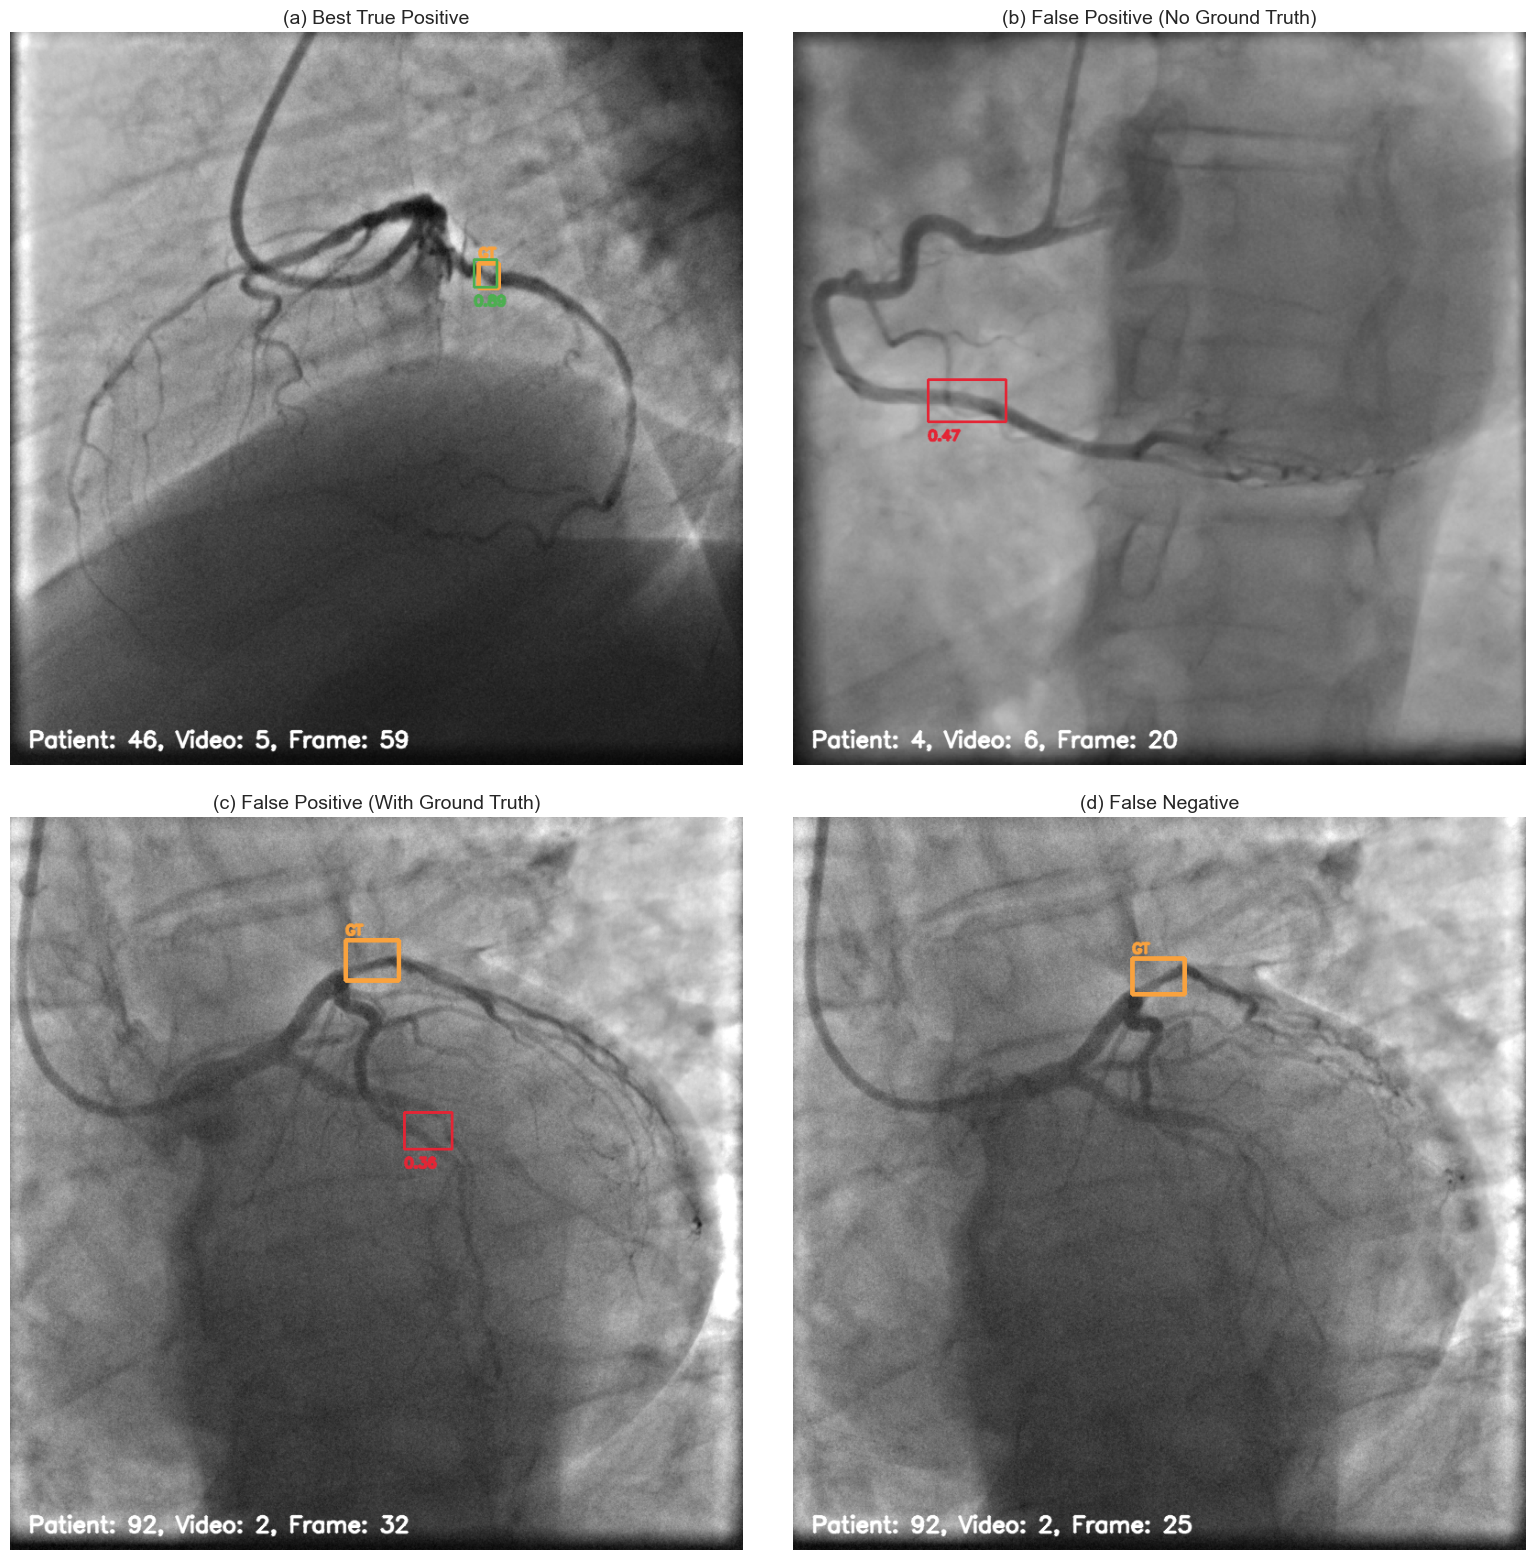

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

for ax, plot_info in zip(axes.flatten(), cases_to_plot):
    visualize_predictions(xca_image=plot_info['image'], result_entry=plot_info['result_entry'], ax=ax, return_ax=True)
    ax.set_title(plot_info['title'], fontsize=14) # add title for context in notebook
    
    meta = plot_info['result_entry']['metadata']
    p_id, v_id, f_nr = meta['patient_id'], meta['video_id'], meta['frame_nr']
    
    filename = f"fpn_{plot_info['name']}_p{p_id}_v{v_id}_f{f_nr}.png"
    save_path = save_dir / filename
    
    renderer = fig.canvas.get_renderer()
    bbox = ax.get_tightbbox(renderer).transformed(fig.dpi_scale_trans.inverted())
    
    fig.savefig(save_path, bbox_inches=bbox, dpi=300)
    print(f"Saved: {filename}")

plt.tight_layout()
plt.show()

## Figure 6

In [25]:
def find_matching_clips(df, patient_id, video_id, fpn_frame_nr):
    """
    Finds matching clips from sequence models for a given fpn frame.
    """
    group_df = df[(df['patient_id'] == patient_id) & (df['video_id'] == video_id)]

    # isolate fpn entries and find the frame number offset
    fpn_group = group_df[group_df['model_id'] == 'fpn']
    if fpn_group.empty:
        print(f"No FPN data found for patient {patient_id}, video {video_id}.")
        return pd.DataFrame()

    frame_offset = fpn_group['frame_nr'].min()
    relative_frame = fpn_frame_nr - frame_offset # get relative frame due to dataset frame_nr handling bug
   
    sequence_models_df = group_df[group_df['model_id'] != 'fpn']  # isolate sequence model data

    matching_clips = sequence_models_df[  # clips where the relative frame is within the clip's range
        (sequence_models_df['clip_start_frame'] <= relative_frame) &
        (sequence_models_df['clip_end_frame'] >= relative_frame)
    ]
    return matching_clips, relative_frame

In [26]:
fpn_worst_df = fpn_df.sort_values(by="difficulty_score", ascending=True)

for i, row in fpn_worst_df.iterrows():
    pid, vid, frame = row['patient_id'], row['video_id'], row['frame_nr']

    # use the matching function, if the resulting dataframe has 2 rows, that means we have a matching frame for all three models
    matching_clips, relative_frame = find_matching_clips(df_interesting, patient_id=pid, video_id=vid, fpn_frame_nr=frame)
    if len(matching_clips) == 2:
        print(f'Found matching entries at: Patient: {pid}, Video {vid}, Frame: {frame}, Relative Frame: {relative_frame}')
        break

matching_clips

Found matching entries at: Patient: 95, Video 2, Frame: 39.0, Relative Frame: 9.0


model_id  patient_id  video_id item_type  frame_nr  clip_start_frame  \
1114     tsm_t16          95         2      clip       0.0               5.0   
1147  thanos_t16          95         2      clip       0.0               5.0   

      clip_end_frame  num_tp  num_fp  num_fn  num_gt  num_preds  \
1114            20.0      15       1       1      16         16   
1147            20.0      16       0       0      16         16   

      best_pred_score  best_pred_label  best_pred_frame_nr  pred_box_area  \
1114         0.927246              1.0                 6.0    1326.729980   
1147         0.725586              1.0                 9.0    1544.680542   

      gt_box_area  difficulty_score  precision  recall  
1114       1584.0                 2     0.9375  0.9375  
1147       1638.0                 0     1.0000  1.0000

In [27]:
def get_targets_preds_temporal(patient_id: int, video_id: int, frame_nr: int, fpn_results: list, tsm_results: list, thanos_results: list) -> tuple:
    """
    Retrieves targets and predictions for a given patient, video, and frame.
    """
    # fpn lookup
    fpn_target, fpn_pred = get_tgts_preds(fpn_results,
        {"patient_id": patient_id, "video_id": video_id, "frame_nr": frame_nr}
    )
    fpn_boxes = fpn_target[0]["boxes"]

    # find the corresponding tsm and thanos entries
    try:
        tsm_entry, thanos_entry = next(
            (tsm, thanos) for tsm, thanos in zip(tsm_results, thanos_results)
            if (
                tsm.get("metadata", {}).get("patient_id") == patient_id and
                tsm.get("metadata", {}).get("video_id") == video_id
            )
        )
    except StopIteration:
        raise ValueError(
            f"No matching TSM/THANOS entries for patient={patient_id}, video={video_id}"
        )

    # locate the index where boxes match
    index = next(
        idx for idx, (t_tgt, th_tgt) in enumerate(zip(tsm_entry["targets"], thanos_entry["targets"]))
        if torch.equal(fpn_boxes, t_tgt["boxes"]) and torch.equal(fpn_boxes, th_tgt["boxes"])
    )

    # extract matching targets and predictions
    tsm_target = tsm_entry["targets"][index]
    thanos_target = thanos_entry["targets"][index]
    tsm_pred = tsm_entry["predictions"][index]
    thanos_pred = thanos_entry["predictions"][index]

    return fpn_target, fpn_pred, tsm_target, tsm_pred, thanos_target, thanos_pred

In [28]:
fpn_results = stage1_results_local['test_results']['final_test_results']
tsm_results = stage2_results_local['tsm_t16']['test_results']['final_test_results']
thanos_results = stage3_results_local['thanos_t16']['test_results']['final_test_results']

In [29]:
def plot_temporal_comparison(
    patient_id: int, video_id: int, start_frame: int,
    interval: int,steps: int,
    fpn_results, tsm_results, thanos_results,
    figure_name: str
):
    # prepare and define
    model_names = ['FPNRetinaNet', 'TSMRetinaNet', 'THANOS']  # while not fully used, ill keep them here for future extension
    frames = [start_frame + i * interval for i in range(steps)]
    metadata_base = {"patient_id": patient_id, "video_id": video_id}

    # create 3 x steps grid
    fig, axes = plt.subplots(3, steps, figsize=(6 * steps, 6 * len(model_names)))

    # iterate the selected frames and get image
    for col, frame_nr in enumerate(frames):
        fpn_t, fpn_p, tsm_t, tsm_p, thanos_t, thanos_p = get_targets_preds_temporal(
            patient_id=patient_id,
            video_id=video_id,
            frame_nr=frame_nr,
            fpn_results=fpn_results,
            tsm_results=tsm_results,
            thanos_results=thanos_results
        )
        image = reader.get(patient_id=patient_id, video_id=video_id, frame_nr=frame_nr)

        # align targets and preds into lists
        targets = [fpn_t, tsm_t, thanos_t]
        preds   = [fpn_p, tsm_p, thanos_p]

        # plot each models results in its row
        for row, (ax, name, t, p) in enumerate(zip(axes[:, col], model_names, targets, preds)):
            entry = {
                "metadata": {**metadata_base, "frame_nr": frame_nr},
                "targets": t if isinstance(t, (list, tuple)) else [t],
                "predictions": p if isinstance(p, (list, tuple)) else [p],
            }
            visualize_predictions(
                xca_image=image,
                result_entry=entry,
                ax=ax,
                return_ax=True
            )
            ax.set_yticks([])

    # final touches
    plt.tight_layout()
    fig.savefig(figure_name)
    plt.show()

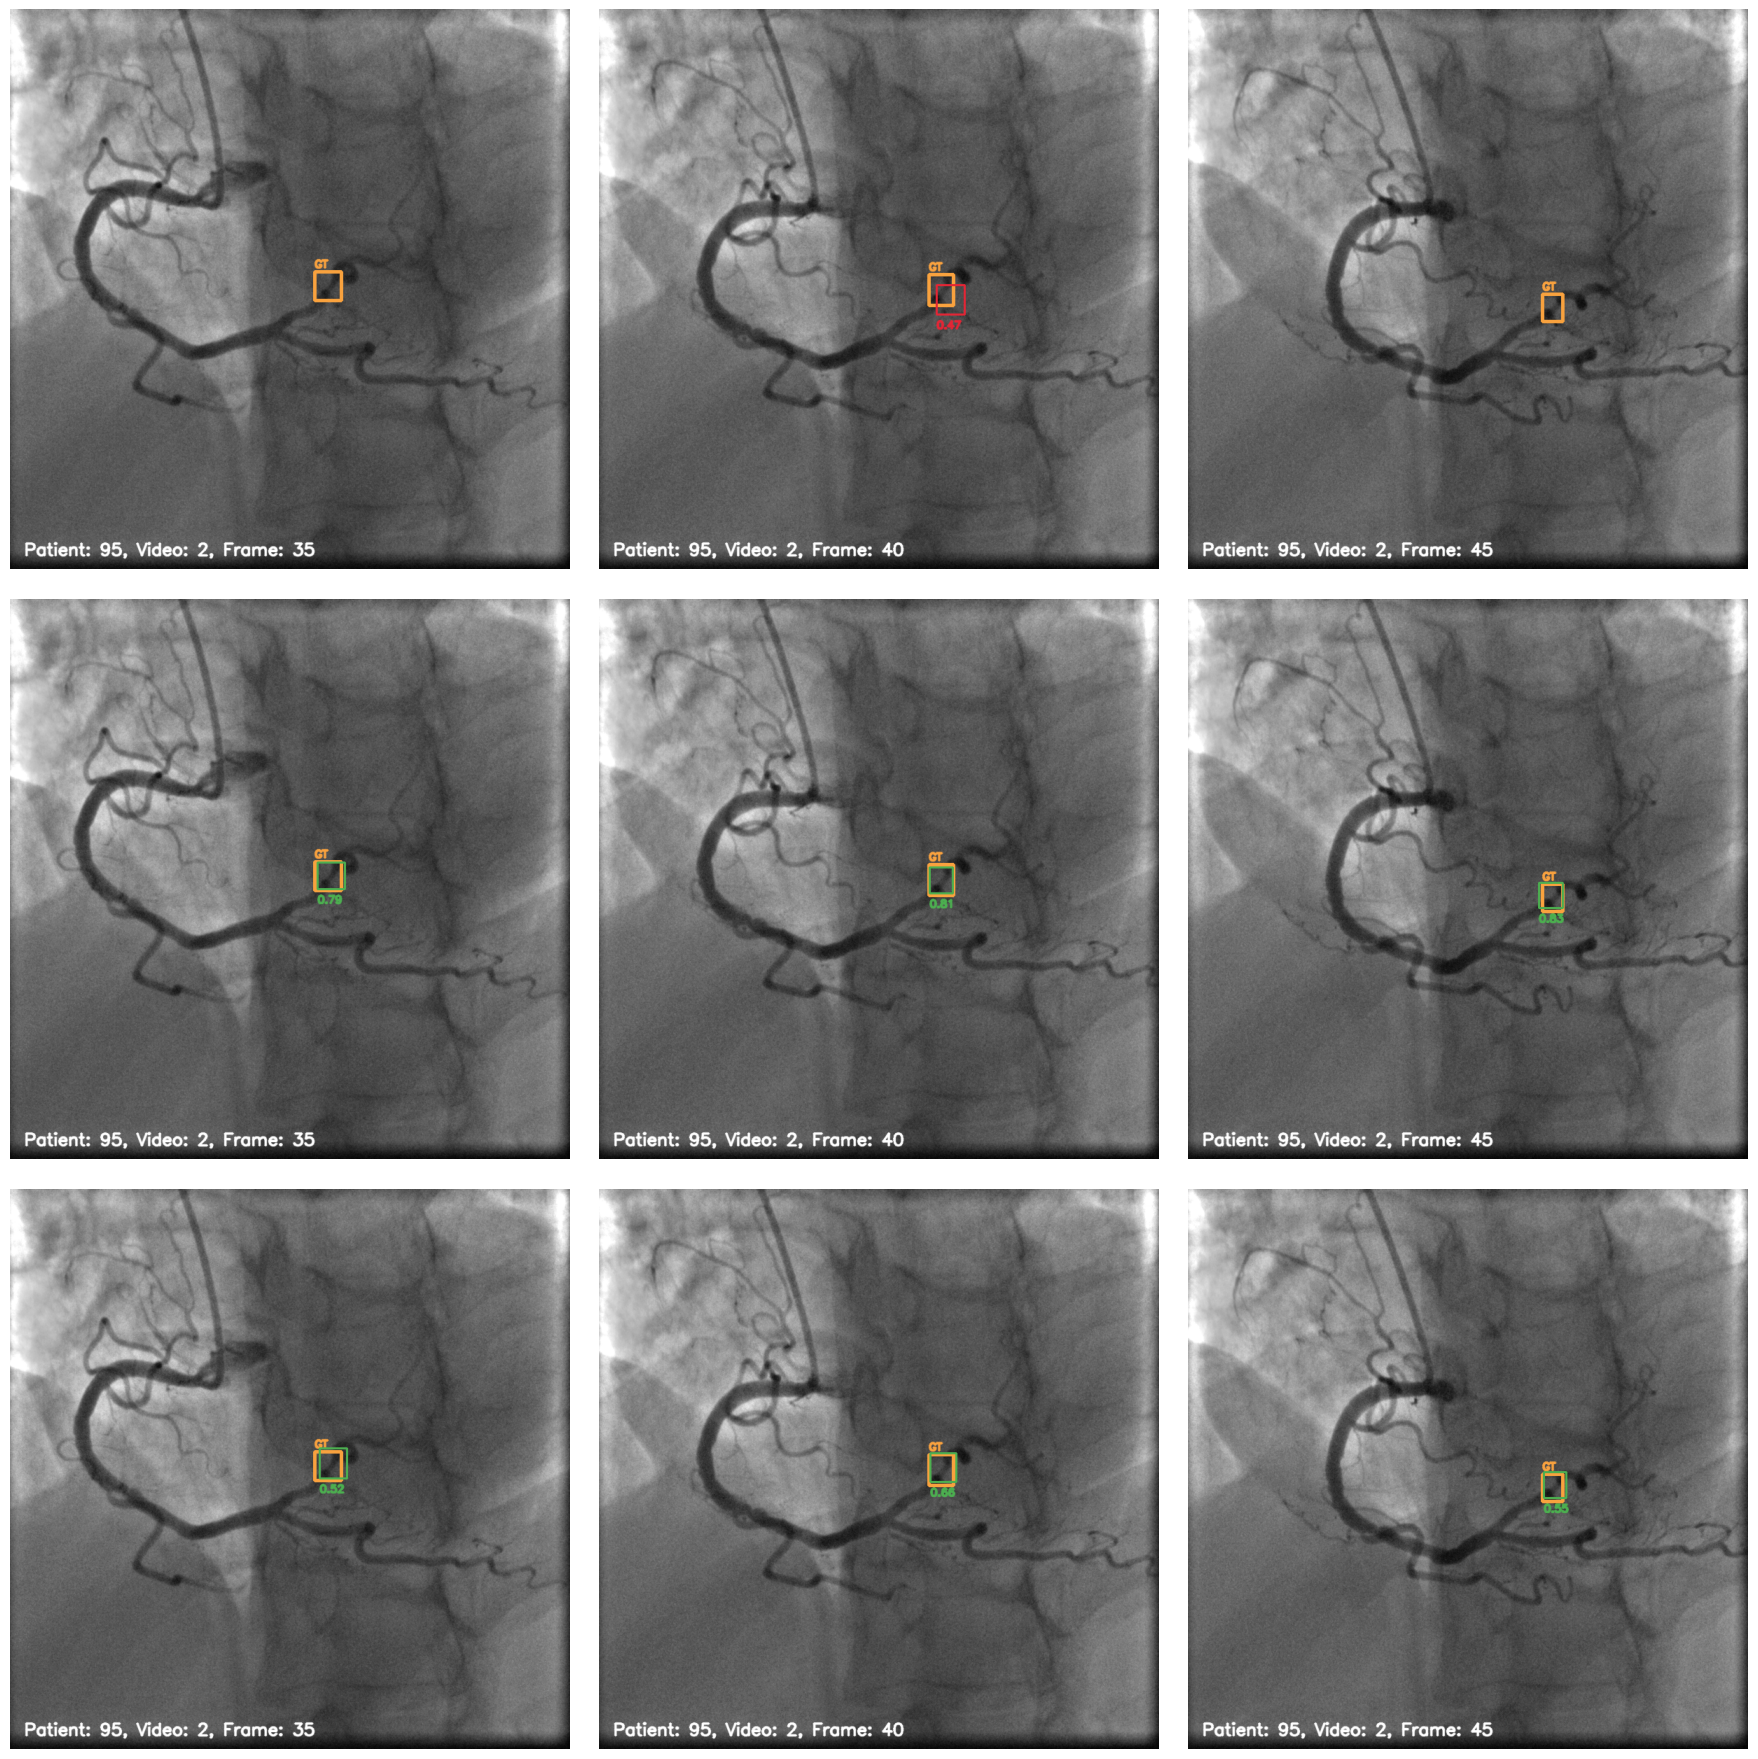

In [30]:
plot_temporal_comparison(patient_id=95, video_id=2, start_frame=35, interval=5, steps=3,
    fpn_results=fpn_results, tsm_results=tsm_results, thanos_results=thanos_results,
    figure_name=RESULTS_DIR / "ex_comparison_temporal.png"
)

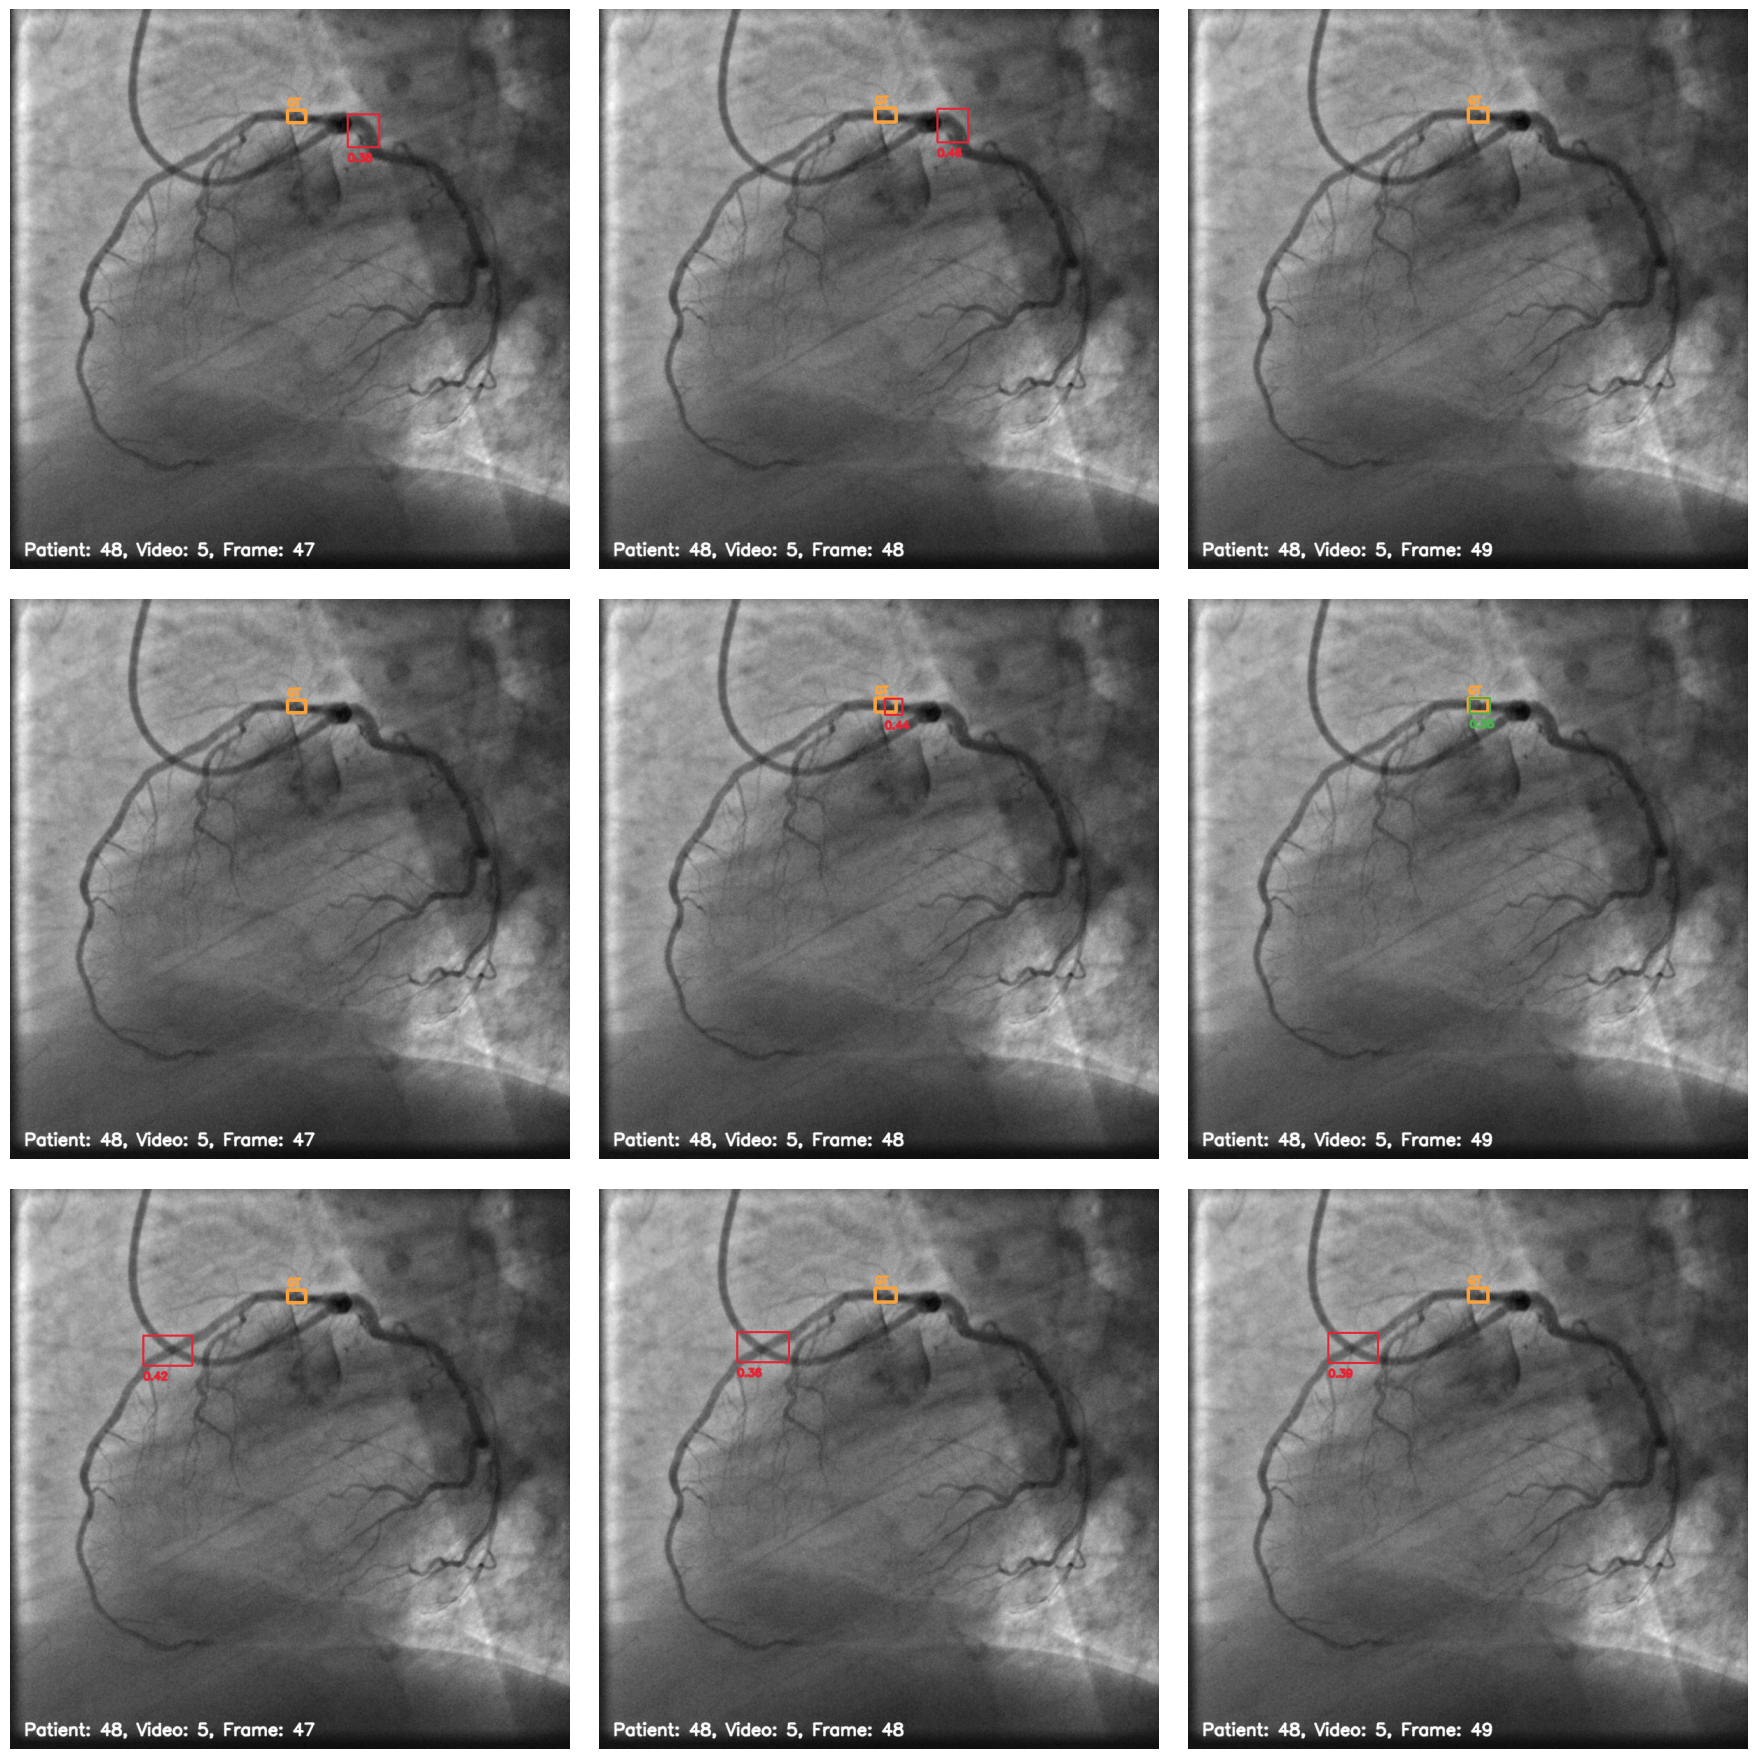

In [31]:
plot_temporal_comparison(patient_id=48, video_id=5, start_frame=47, interval=1, steps=3,
    fpn_results=fpn_results, tsm_results=tsm_results, thanos_results=thanos_results,
    figure_name=RESULTS_DIR / "ex_comparison_temporal_small.png"
)

In [ ]:
# Goodbye!